In [1]:
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import random
import torch
import matplotlib.pyplot as plt

In [2]:
tokenizer = AutoTokenizer.from_pretrained("gpt2-xl", return_tensors = 'pt')
tokenizer.pad_token = tokenizer.eos_token

In [35]:
def calculate_batch_perplexity(model, texts, batch_size=50):
    generations = {}
    generations['input'] = []
    generations['output'] = []
    perplexities = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Generating Samples"):
        input_texts = texts[i : i + batch_size]
        generations['input'].extend(input_texts)
        inputs = tokenizer(input_texts, return_tensors="pt", padding=True, max_length=512, truncation=True)
        input_ids = inputs['input_ids'].to(model.device)
        attention_mask = inputs['attention_mask'].to(model.device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = input_ids[:, 1:].contiguous()
        shift_attention_mask = attention_mask[:, 1:].contiguous()

        log_probs = torch.nn.functional.log_softmax(shift_logits, dim=-1)
        target_log_probs = log_probs.gather(dim=-1, index=shift_labels.unsqueeze(-1)).squeeze(-1)
        target_log_probs = target_log_probs * shift_attention_mask
        
        for j in range(len(input_texts)):
            seq_len = shift_attention_mask[j].sum().item()
            if seq_len > 0:
                neg_log_likl = -target_log_probs[j].sum().item()
                avg_neg_log_likl = neg_log_likl / seq_len
                perplexity = torch.exp(torch.tensor(avg_neg_log_likl)).item()
                if torch.isnan(torch.tensor(perplexity)) or torch.isinf(torch.tensor(perplexity)):
                    print(f"Warning: Invalid perplexity {perplexity} for sequence {j}")
                    perplexity = float('inf')
                    
                perplexities.append(perplexity)
            else:
                # Skip sequences with no valid tokens
                perplexities.append(float('inf'))
        
        output_texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
        generations['output'].extend(output_texts)
    
    valid_perplexities = [p for p in perplexities if p != float('inf')]
    if valid_perplexities:
        mean_perplexity = sum(valid_perplexities) / len(valid_perplexities)
    else:
        mean_perplexity = float('inf')   
    return mean_perplexity, generations

In [36]:
def parse_wet_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        
    documents = re.split(r'WARC/1.0', content)
    texts = []
    
    for doc in documents:
        if "WARC-Identified-Content-Language: eng" in doc:
            match = re.search(r'Content-Length: \d+\n\n(.*)', doc, re.DOTALL)
            if match:
                text = match.group(1)
                texts.append(text)
    
    return texts

In [37]:
def sample_random_prompts(texts, num_samples=25000, prompt_length=10):
    prompts = []
    for text in texts:
        tokens = text.split()
        
        if len(tokens) >= prompt_length:
            start_index = random.randint(0, len(tokens) - prompt_length)
            prompt = tokens[start_index:start_index + prompt_length]
            prompts.append(' '.join(prompt))
        
        if len(prompts) >= num_samples:
            break
    
    return prompts

In [38]:
def extract_emails(text):
    emails = re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', text)
    emails = [email.lower() for email in emails]
    return set(emails)

In [39]:
with open('datasets/enron/training.txt', 'r') as file:
    train_data = file.read()
ORIGINAL_SET = extract_emails(train_data)

In [40]:
len(ORIGINAL_SET)

23394

In [41]:
def num_times_email_leaked(emails, email):
    num_times = 0
    for mail in emails:
        if mail == email:
            num_times += 1
    return num_times

In [42]:
def generate_samples(wet_file_path, batch_size = 50, num_samples = 25000, max_length = 256):
    texts = parse_wet_file(wet_file_path)
    prompts = sample_random_prompts(texts, num_samples)
    tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
    folder_path = "models"
    checkpoints = [os.path.join(folder_path, ckpt) for ckpt in os.listdir(folder_path)]
    for ckpt in checkpoints:
        if ckpt == "models/120e3":
            continue
        print(f'processing : {ckpt}')
        model = AutoModelForCausalLM.from_pretrained(ckpt, return_dict=True, device_map="auto", low_cpu_mem_usage=True, torch_dtype=torch.float16)
        model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        os.makedirs("generations", exist_ok = True)
        os.makedirs("email_collection", exist_ok=True)
        
        checkpoint_name = ckpt.split('/')[-1]
        generation_name = f"generations/{checkpoint_name}_masked.txt"
        df_name = f"email_collection/{checkpoint_name}_masked.csv"
        
        ckpt_summ = {}
        ckpt_summ['prompt'] = []
        ckpt_summ['email_leaked'] = []
        ckpt_summ['email'] = []
        
        with open(generation_name, 'w') as file:
            for i in tqdm(range(0, len(prompts), batch_size), desc = "Extracting Emails"):
                batched_prompts = prompts[i:i+batch_size]
                inputs = tokenizer(batched_prompts, return_tensors = 'pt', truncation = True, max_length = 10).to(device)
                with torch.no_grad():
                    outputs = model.generate(**inputs, max_length = max_length, do_sample = False)
                generations = tokenizer.batch_decode(outputs, skip_special_tokens = True)
                for idx, generation in enumerate(generations):
                    file.write(f"{i+idx+1}. {generation}\n\n")
                for no in range(len(generations)):
                    emails_leaked = extract_emails(generations[no])
                    leakage_set = set(emails_leaked)
                    for email in leakage_set:
                        if email in ORIGINAL_SET:
                            ckpt_summ['prompt'].append(batched_prompts[no])
                            ckpt_summ['email'].append(email)
                            num_times_leaked = num_times_email_leaked(emails_leaked, email)
                            ckpt_summ['email_leaked'].append(num_times_leaked)
        ckpt_df = pd.DataFrame(ckpt_summ)
        ckpt_df.to_csv(df_name, index = False)
        
                            
        
        

In [47]:
def generate_perplexities(wet_file_path, batch_size = 50, num_samples = 25000, max_length = 256):
    results = {}
    results['checkpoint'] = []
    results['mean_perplexity'] = []
    texts = parse_wet_file(wet_file_path)
    prompts = sample_random_prompts(texts, num_samples)
    tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
    folder_path = "models"
    checkpoints = [os.path.join(folder_path, ckpt) for ckpt in os.listdir(folder_path)]
    for ckpt in checkpoints:
        if ckpt == "models/120e3":
            continue
        print(f'processing : {ckpt}')
        model = AutoModelForCausalLM.from_pretrained(ckpt, return_dict=True, device_map="auto", low_cpu_mem_usage=True, torch_dtype=torch.float16)
        model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        os.makedirs("generations", exist_ok = True)
        os.makedirs("email_collection", exist_ok=True)
        
        checkpoint_name = ckpt.split('/')[-1]
        generation_name = f"generations/{checkpoint_name}.txt"
        df_name = f"email_collection/{checkpoint_name}.csv"

        iter_no, epoch_no = checkpoint_name.split('e')
        iter_no = int(iter_no)
        epoch_no = int(epoch_no)
        ckpt = (epoch_no - 1) * 100 + iter_no
        results['checkpoint'].append(ckpt)
        
        perplexity, ckpt_summ = calculate_batch_perplexity(model, prompts)
        results['mean_perplexity'].append(perplexity)
        ckpt_df = pd.DataFrame(ckpt_summ)
        ckpt_df.to_csv(df_name, index = False)
    res_df = pd.DataFrame(results)
    res_df.to_csv('results/perp_calc_unmasked.csv', index = False)
        
                            
        
        

In [48]:
generate_perplexities('crawl.wet', batch_size = 100, num_samples = 25000)

processing : models/100e1


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.92it/s]


processing : models/100e2


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.99it/s]


processing : models/100e3


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.91it/s]


processing : models/10e1


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.92it/s]


processing : models/10e2


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.95it/s]


processing : models/10e3


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.92it/s]


processing : models/110e3


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.98it/s]


processing : models/20e1


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.90it/s]


processing : models/20e2


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.93it/s]


processing : models/20e3


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.97it/s]


processing : models/30e1


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.98it/s]


processing : models/30e2


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.93it/s]


processing : models/30e3


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.93it/s]


processing : models/40e1


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.93it/s]


processing : models/40e2


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.93it/s]


processing : models/40e3


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.92it/s]


processing : models/50e1


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.95it/s]


processing : models/50e2


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.98it/s]


processing : models/50e3


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.91it/s]


processing : models/60e1


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.91it/s]


processing : models/60e2


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.94it/s]


processing : models/60e3


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.98it/s]


processing : models/70e1


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.92it/s]


processing : models/70e2


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.94it/s]


processing : models/70e3


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.93it/s]


processing : models/80e1


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.96it/s]


processing : models/80e2


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.99it/s]


processing : models/80e3


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.95it/s]


processing : models/90e1


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.95it/s]


processing : models/90e2


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.96it/s]


processing : models/90e3


Generating Samples: 100%|██████████| 313/313 [00:09<00:00, 33.98it/s]


In [51]:
results_df = pd.read_csv("results/perp_calc_unmasked.csv")
results_df.head()

results_df = results_df.sort_values('checkpoint')
results_df.head()

,checkpoint,mean_perplexity
3,10,1168.112503
7,20,1320.437121
10,30,1357.508063
13,40,1440.557614
16,50,1477.163551


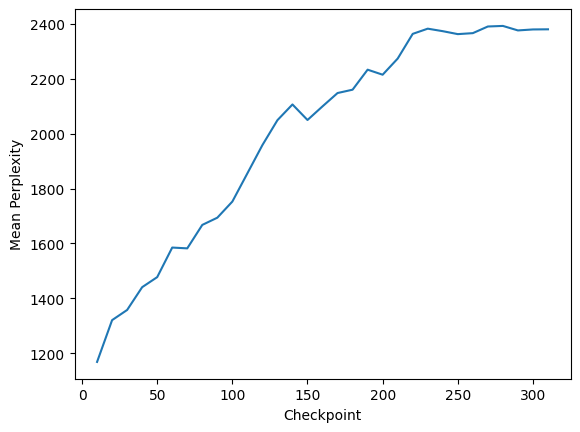

In [53]:
plt.plot(results_df['checkpoint'], results_df['mean_perplexity'])
plt.xlabel("Checkpoint")
plt.ylabel("Mean Perplexity")

plt.show()

In [13]:
DATA_PATH = 'data'
CSV_PATH = 'email_collection'


csv_files = [os.path.join(CSV_PATH, csv) for csv in os.listdir(CSV_PATH)]

In [14]:
perc_leaked_from_seen = {}
perc_leaked_from_total = {}
emails_leaked = {}
email_sets = {}
for csvfile in csv_files:
    if 'masked' not in csvfile:
        continue
    try:
        print(f"Working on: {csvfile}")
        filename = csvfile.replace('_masked', '')
        filename = filename.split('/')[-1].replace('.csv','')
        print(filename)
        perc, epoch = filename.split('e')
        datafile = f'{DATA_PATH}/{epoch}e{perc}.txt'
        with open(datafile, 'r') as file:
            data = file.read()
        emails_seen = extract_emails(data)
        #emails_seen = emails_seen & ORIGINAL_SET
        print(len(emails_seen))
        emails_df = pd.read_csv(csvfile)
        emails_extracted = set(emails_df['email'].to_list())
        perc, epoch = filename.split('e')
        percentage = (int(epoch)-1)*100 + int(perc)
        emails_leaked[percentage] = len(emails_extracted)
        email_sets[percentage] = emails_extracted
        perc_leaked_from_seen[percentage] = (len(emails_extracted)/len(emails_seen))*100
        perc_leaked_from_total[percentage] = (len(emails_extracted)/len(ORIGINAL_SET))*100
    except Exception as e:
        print(e)
        continue

Working on: email_collection/100e1_masked.csv
100e1
6436
Working on: email_collection/100e2_masked.csv
100e2
6554
Working on: email_collection/100e3_masked.csv
100e3
6256
Working on: email_collection/10e1_masked.csv
10e1
6252
Working on: email_collection/10e2_masked.csv
10e2
6479
Working on: email_collection/10e3_masked.csv
10e3
6431
Working on: email_collection/110e3_masked.csv
110e3
[Errno 2] No such file or directory: 'data/3e110.txt'
Working on: email_collection/20e1_masked.csv
20e1
6432
Working on: email_collection/20e2_masked.csv
20e2
6151
Working on: email_collection/20e3_masked.csv
20e3
6483
Working on: email_collection/30e1_masked.csv
30e1
6526
Working on: email_collection/30e2_masked.csv
30e2
6216
Working on: email_collection/30e3_masked.csv
30e3
6385
Working on: email_collection/40e1_masked.csv
40e1
6330
Working on: email_collection/40e2_masked.csv
40e2
6264
Working on: email_collection/40e3_masked.csv
40e3
6327
Working on: email_collection/50e1_masked.csv
50e1
6281
Working 

In [15]:
perc_leaked_from_seen = dict(sorted(perc_leaked_from_seen.items(), key = lambda x: x[0]))
perc_leaked_from_total = dict(sorted(perc_leaked_from_total.items(), key = lambda x: x[0]))
emails_leaked = dict(sorted(emails_leaked.items(), key = lambda x: x[0]))

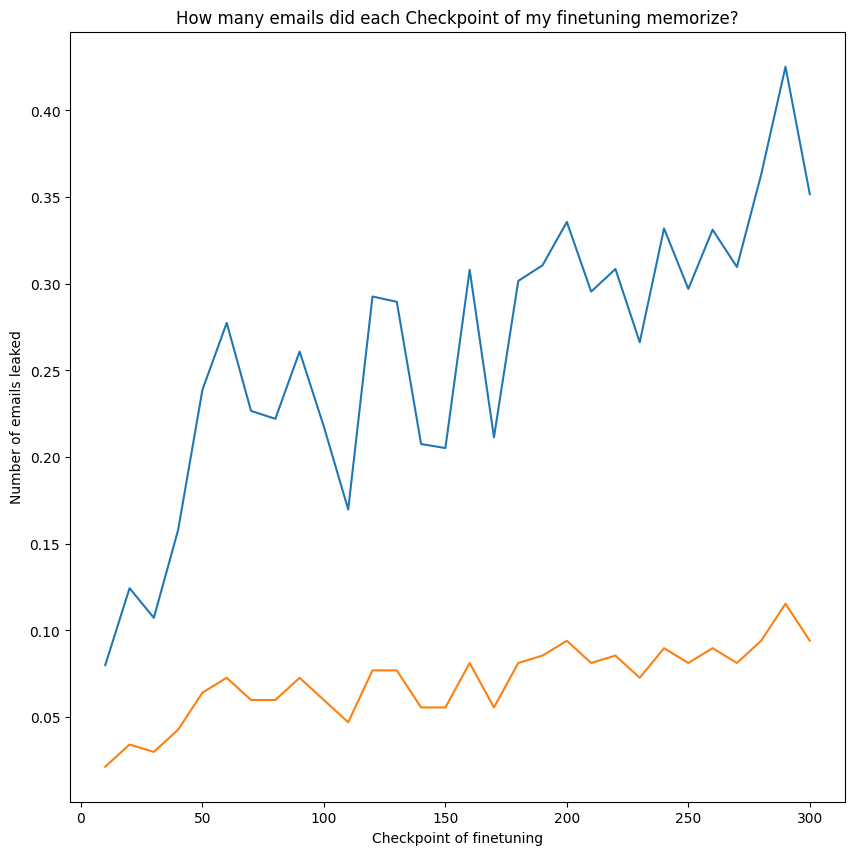

In [16]:
plt.figure(figsize=(10, 10))
plt.plot(perc_leaked_from_seen.keys(), perc_leaked_from_seen.values())
plt.plot(perc_leaked_from_total.keys(), perc_leaked_from_total.values())
plt.xlabel('Checkpoint of finetuning')
plt.ylabel('Number of emails leaked')
plt.title('How many emails did each Checkpoint of my finetuning memorize?')
plt.show()

In [17]:
df = pd.read_csv('results/results.csv')
df.head()

,checkpoint,percentage_from_total_masked,percentage_from_seen_masked,emails_leaked_masked,percentage_from_total_original,percentage_from_seen_original,emails_leaked_original
0,10,0.008549,0.088261,2,0.042746,0.171174,10
1,20,0.017098,0.090539,4,0.081217,0.201634,19
2,30,0.017098,0.059286,4,0.102590,0.196996,24
3,40,0.029922,0.077735,7,0.132513,0.214088,31
4,50,0.029922,0.061328,7,0.162435,0.233243,38


In [18]:
og_percs_total = df['percentage_from_total_original'].to_list()
og_percs_seen = df['percentage_from_seen_original'].to_list()
og_emails_leaked = df['emails_leaked_original'].to_list()

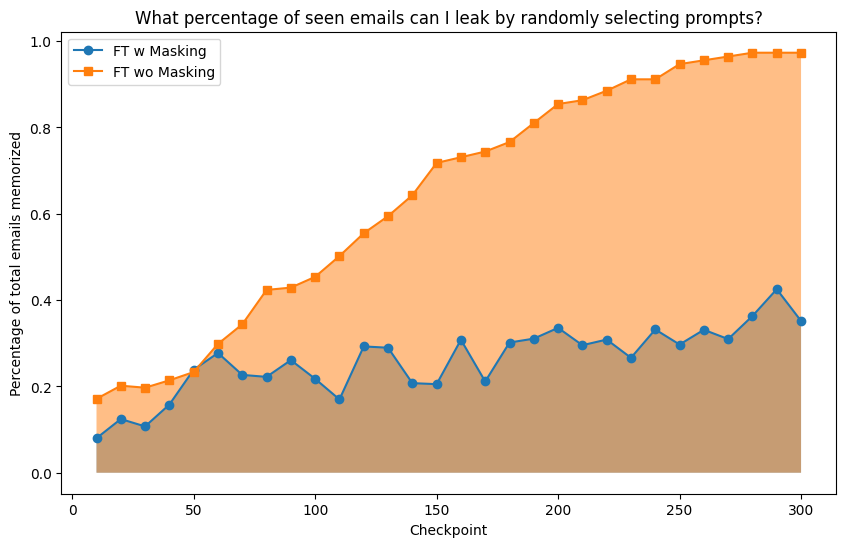

In [19]:
plt.figure(figsize=(10,6))

# Plot the lines
plt.plot(perc_leaked_from_seen.keys(), perc_leaked_from_seen.values(), marker='o', label='FT w Masking')
plt.plot(perc_leaked_from_seen.keys(), og_percs_seen, marker='s', label='FT wo Masking')

# Add fill below the lines
plt.fill_between(perc_leaked_from_seen.keys(), perc_leaked_from_seen.values(), alpha=0.5, label='_nolegend_')
plt.fill_between(perc_leaked_from_seen.keys(), og_percs_seen, alpha=0.5, label='_nolegend_')

plt.xlabel('Checkpoint')
plt.ylabel('Percentage of total emails memorized')
plt.title('What percentage of seen emails can I leak by randomly selecting prompts?')
plt.legend()
plt.show()

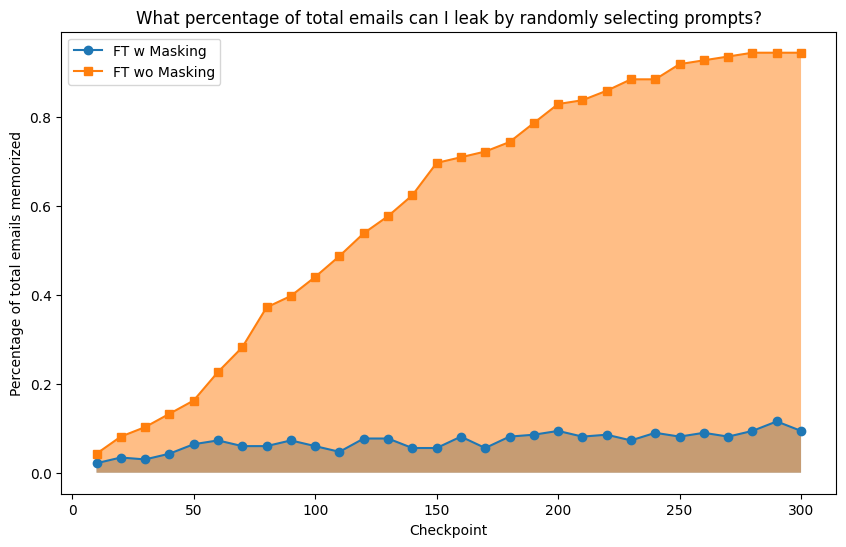

In [20]:
plt.figure(figsize=(10,6))

# Plot the lines
plt.plot(perc_leaked_from_total.keys(), perc_leaked_from_total.values(), marker='o', label='FT w Masking')
plt.plot(perc_leaked_from_total.keys(), og_percs_total, marker='s', label='FT wo Masking')

# Add fill below the lines
plt.fill_between(perc_leaked_from_seen.keys(), perc_leaked_from_total.values(), alpha=0.5, label='_nolegend_')
plt.fill_between(perc_leaked_from_seen.keys(), og_percs_total, alpha=0.5, label='_nolegend_')

plt.xlabel('Checkpoint')
plt.ylabel('Percentage of total emails memorized')
plt.title('What percentage of total emails can I leak by randomly selecting prompts?')
plt.legend()
plt.show()

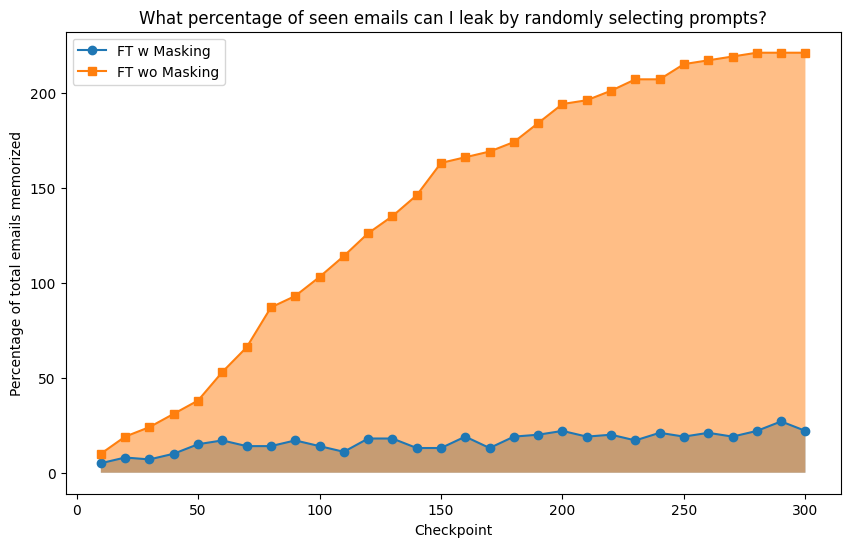

In [21]:
plt.figure(figsize=(10,6))

# Plot the lines
plt.plot(perc_leaked_from_total.keys(), emails_leaked.values(), marker='o', label='FT w Masking')
plt.plot(perc_leaked_from_total.keys(), og_emails_leaked, marker='s', label='FT wo Masking')

# Add fill below the lines
plt.fill_between(perc_leaked_from_seen.keys(), emails_leaked.values(), alpha=0.5, label='_nolegend_')
plt.fill_between(perc_leaked_from_seen.keys(), og_emails_leaked, alpha=0.5, label='_nolegend_')

plt.xlabel('Checkpoint')
plt.ylabel('Percentage of total emails memorized')
plt.title('What percentage of seen emails can I leak by randomly selecting prompts?')
plt.legend()
plt.show()